In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipyfilechooser import FileChooser

# Analysis of submission 2 

In this tutorial we will use submission 2, as we can do both the all vs all analysis and the all vs GT analysis. Let's do all vs GT first.

## Computing SVD from Ground Truth and projection submissions

First I will load the example config file we provided so we can look at the keys it has

In [3]:
# Select path to SVD config file
# An example of this file is available in the path ../config_files/config_svd.yaml
config_svd_path = FileChooser(os.path.expanduser("~"))
config_svd_path.filter_pattern = '*.yaml'
display(config_svd_path)

FileChooser(path='/mnt/home/gwoollard', filename='', title='', show_hidden=False, select_desc='Select', change…

In [4]:
with open(config_svd_path.value, "r") as f:
    config_example = yaml.safe_load(f)

In [5]:
print(f"keys for config: {config_example.keys()}")
print(f"keys for output_options: {config_example['output_options'].keys()}")

keys for config: dict_keys(['path_to_volumes', 'box_size_ds', 'submission_list', 'experiment_mode', 'path_to_reference', 'dtype', 'output_options'])
keys for output_options: dict_keys(['output_path', 'save_volumes', 'save_svd_matrices'])


Here is a brief explanation of each key

* path_to_volumes (str): this is the path to your submissions (the result of running the preprocessing). They should be called submission_0.pt, submission_1.pt, ...
* box_size_ds (int): you can choose to downsample the volumes to speed up the analysis, or to get rid of high frequency features.
* submission_list (List): here you can choose which submissions are used for the analysis. If you want to use submissions 0, 3, 6; then this should be [0, 3, 6]
* experiment_mode (str): the options are "all_vs_all", "all_vs_ref". If you are using ref, then SVD is computed from the refence volumes and the rest of the volumes are projected to it. Otherwise, all volumes are used to do the projection
* path_to_reference (str): path to the reference volumes (only needed if mode is "all_vs_ref")
* dtype (str): can be float32 or float64
* output_options (dict): dictionary with options to personalize the output
    * output_path (str): where the volumes will be saved
    * save_volumes (bool): whether or not to save the volumes used (this will save the normalized, downsampled, and mean-removed volumes)
    * save_svd_matrices (bool): whether or not to save the matrices computed from the SVD

After setting up your config, simply run in your terminal (make sure to install and activate the environment)

```bash
cryo_challenge run_svd --config /path/to/config
```

After the code is done running you can load your results as

In [6]:
# Select path to SVD results
svd_results_path = FileChooser(os.path.expanduser("~"))
svd_results_path.filter_pattern = '*.pt'
display(svd_results_path)

FileChooser(path='/mnt/home/gwoollard', filename='', title='', show_hidden=False, select_desc='Select', change…

In [8]:
data_svd_vs_gt = torch.load(svd_results_path.value)

The results look like

In [9]:
data_svd_vs_gt.keys()

dict_keys(['coeffs', 'coeffs_ref', 'metadata', 'config', 'volumes', 'mean_volumes', 'ref_volumes', 'mean_ref_volume', 'U', 'S', 'V'])

In [10]:
data_svd_vs_gt["metadata"]["Salted Caramel"].keys()

dict_keys(['n_vols', 'populations', 'indices'])

Here is a brief description of each key

* coeffs: these are the coefficients of the expansion for the submissions. They are flattened, so their shape is something like `(n_submissions * 80, D**3)`. Where `D` is the box size after downsampling.

* coeffs_ref: similar to coeffs, but these are the coefficients for the reference volumes (the ones used to compute the svd).

* metadata: this is a dictionary with information about the submissions, the keys are the id of each submission (the ice cream flavor)
    * n_vols: how many volumes were included in this submission (ideally, 80)
    * populations: normalized submitted populations
    * indices: since the coeffs are flattened, this indices tells you the range for the coefficients of this submission `coeffs[indices[0], indices[1]]`

* config: a copy of the config used to generate the data

If you chose to save volumes. The volumes saved are downsampled, normalized and without mean. The means are provided in case they are necessary.

* volumes: Submission volumes. They are useful for rerunning things or to create animations.
* mean_volumes: mean volumes for each submission
* ref_volumes: same, but for the reference volumes
* mean_ref_volume: mean reference volume.

If you chose to save the singular value matrices
* U: right-singular vectors
* S: singular values
* V_T: left-singular vectors



Here is how to generate the plots we have showed 

Text(0.5, 0.92, "Set2: Projection of each submission onto GT's SVD")

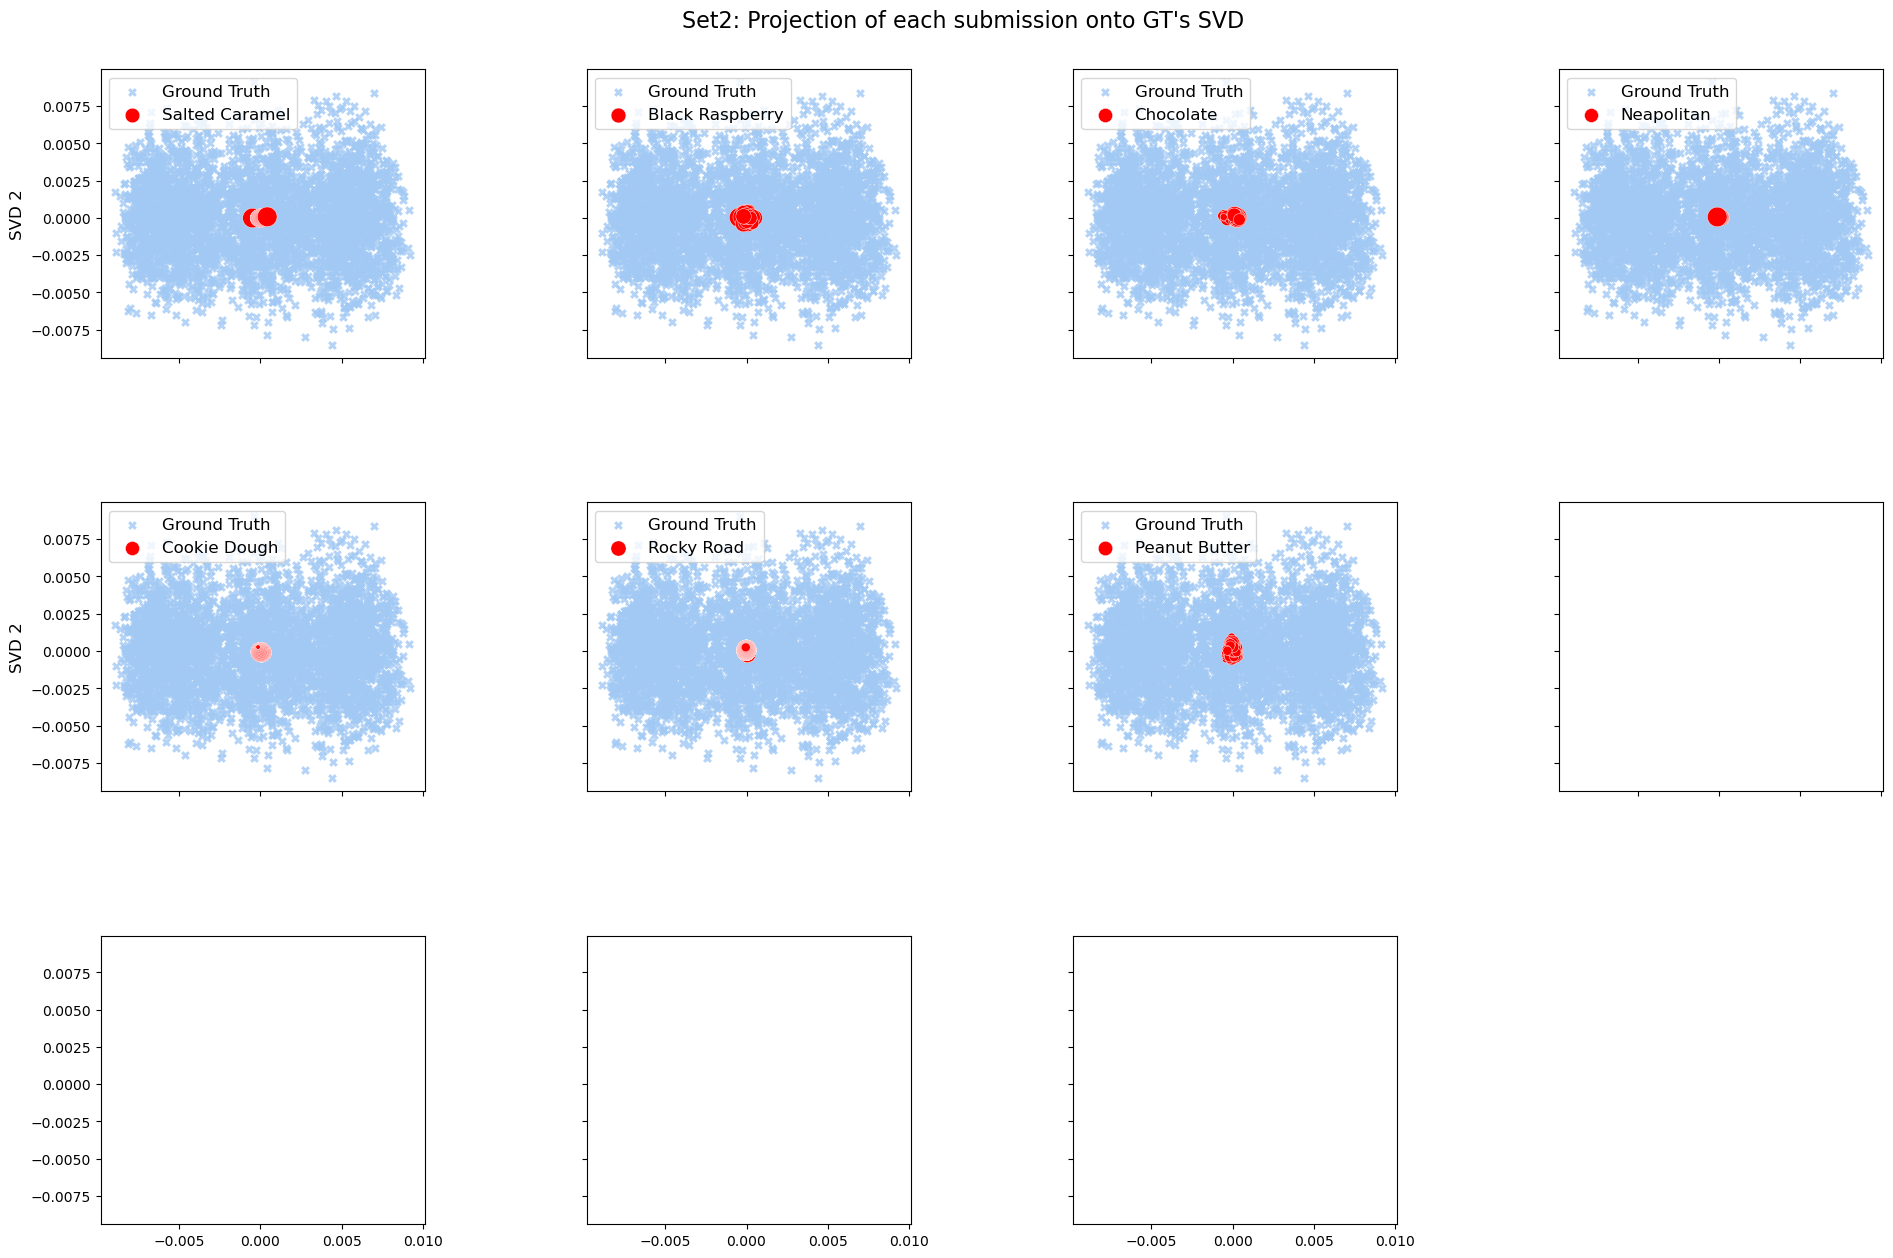

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(23, 15), sharex=True, sharey=True)

for i, id in enumerate(data_svd_vs_gt["metadata"].keys()):
    sns.scatterplot(
        x=data_svd_vs_gt["coeffs_ref"][:, 0],
        y=data_svd_vs_gt["coeffs_ref"][:, 1],
        edgecolors=None,
        linewidth=0,
        marker="X",
        label="Ground Truth",
        ax=ax.flatten()[i],
        s=40,
        alpha=0.8,
        color="#a1c9f4",
    )

    idx_0, idx_1 = data_svd_vs_gt["metadata"][id]["indices"]
    populations = data_svd_vs_gt["metadata"][id]["populations"]

    ax.flatten()[i].scatter(
        x=data_svd_vs_gt["coeffs"][idx_0:idx_1, 0],
        y=data_svd_vs_gt["coeffs"][idx_0:idx_1, 1],
        color="red",
        s=populations / populations.max() * 200,
        marker="o",
        linewidth=0.3,
        edgecolor="white",
        label=id,
    )

    ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
    ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
    ax.flatten()[i].legend(loc="upper left", fontsize=12)

# ax[0].set_title("Submission vs all submissions")
ax[2, 3].axis("off")

# adjust horizontal space
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Set2: Projection of each submission onto GT's SVD", fontsize=16, y=0.92)

Text(0.5, 0.92, "Set2: Projection of each submission onto GT's SVD")

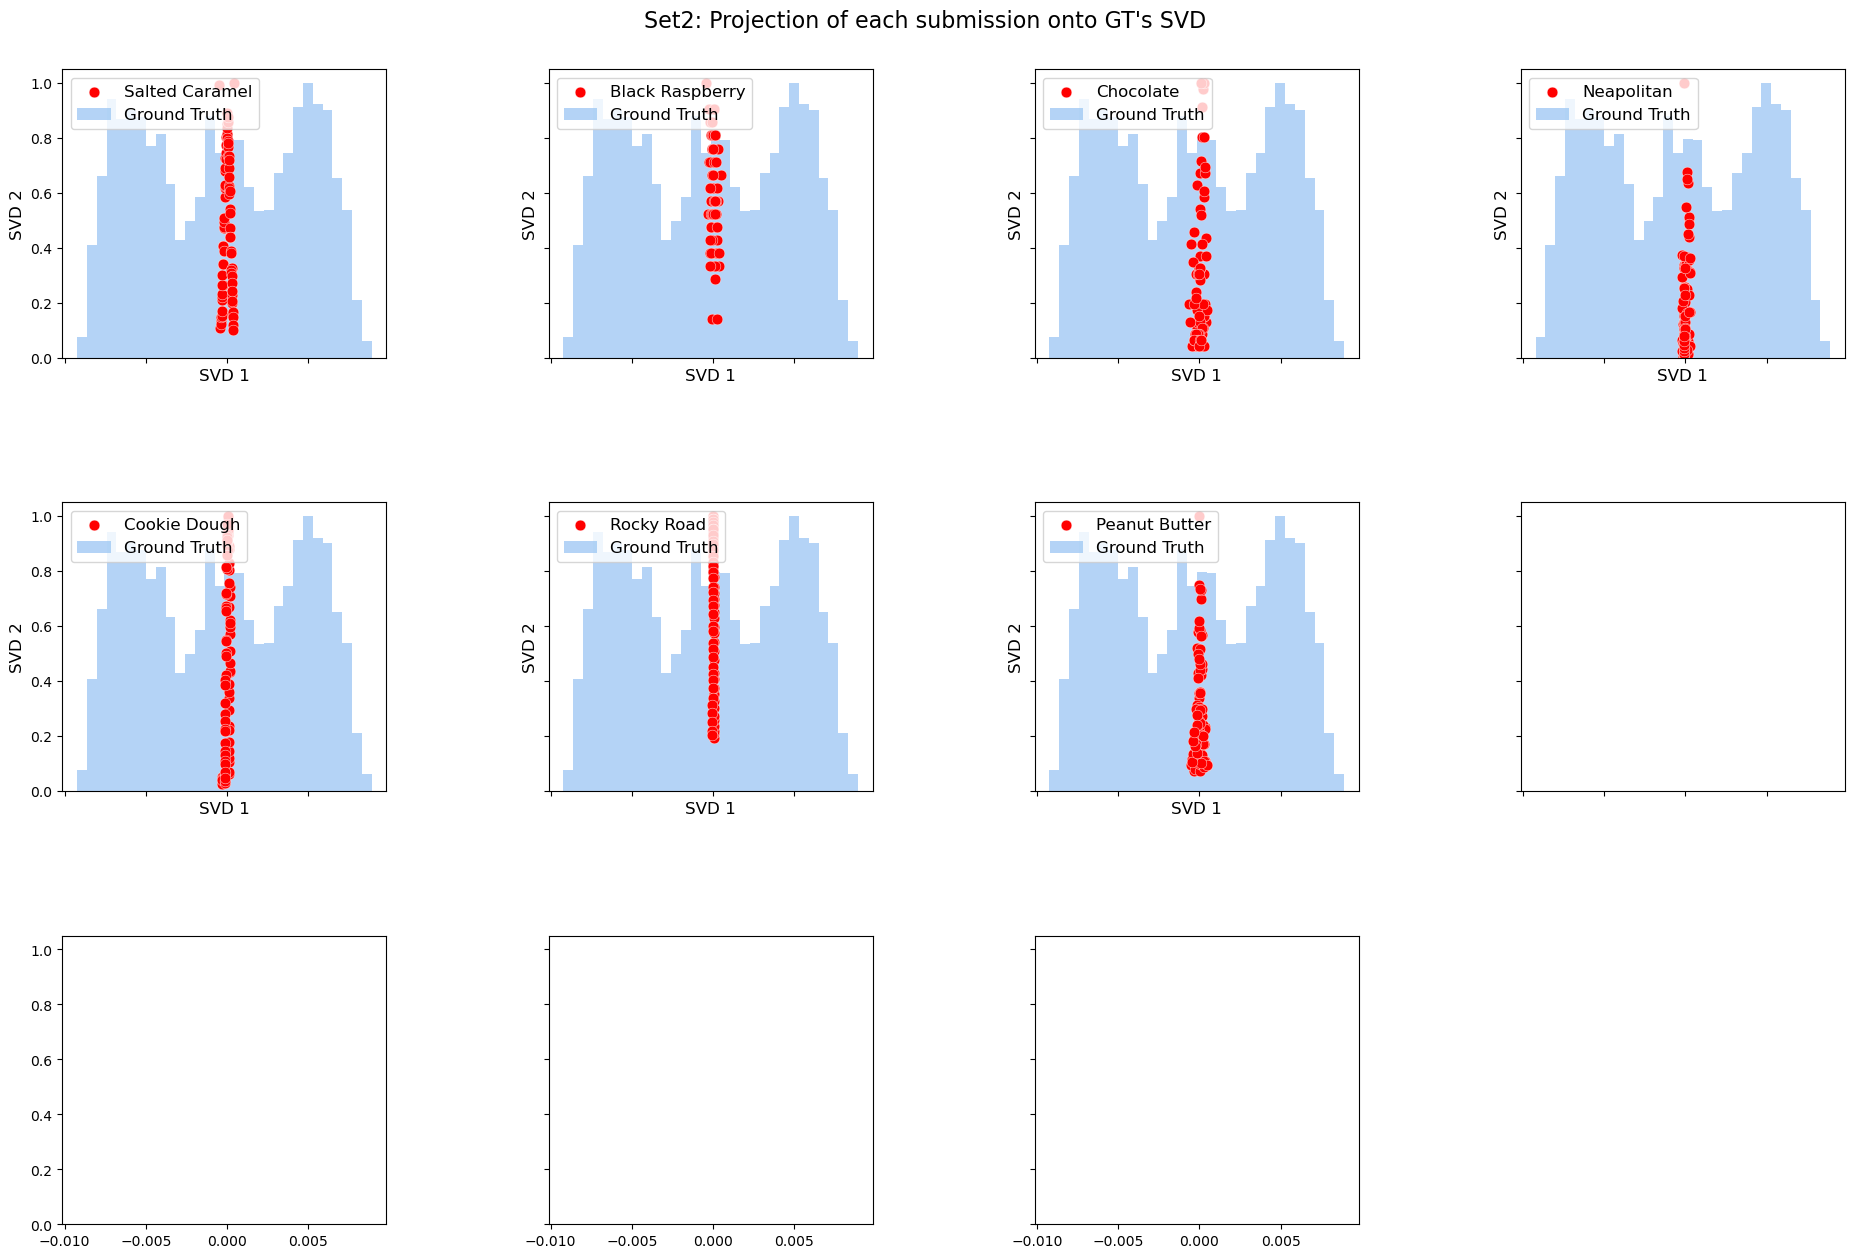

In [12]:
fig, ax = plt.subplots(3, 4, figsize=(23, 15), sharex=True, sharey=True)

for i, id in enumerate(data_svd_vs_gt["metadata"].keys()):
    frq, edges = np.histogram(data_svd_vs_gt["coeffs_ref"][:, 0], bins=30)
    ax.flatten()[i].bar(
        edges[:-1],
        frq / frq.max(),
        width=np.diff(edges),
        label="Ground Truth",
        alpha=0.8,
        color="#a1c9f4",
    )

    idx_0, idx_1 = data_svd_vs_gt["metadata"][id]["indices"]
    populations = data_svd_vs_gt["metadata"][id]["populations"]

    ax.flatten()[i].scatter(
        x=data_svd_vs_gt["coeffs"][idx_0:idx_1, 0],
        y=populations / populations.max(),
        color="red",
        marker="o",
        s=60,
        linewidth=0.3,
        edgecolor="white",
        label=id,
    )

    ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
    ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
    ax.flatten()[i].legend(loc="upper left", fontsize=12)

# ax[0].set_title("Submission vs all submissions")
ax[2, 3].axis("off")

# adjust horizontal space
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Set2: Projection of each submission onto GT's SVD", fontsize=16, y=0.92)

# Comparing submissions to each other (all vs all)

Follow the same instructions as before, but change the mode to all_vs_all. I will leave the code used to generate the images.

In [13]:
# Select path to SVD results
svd_all_vs_all_results_path = FileChooser(os.path.expanduser("~"))
svd_all_vs_all_results_path.filter_pattern = '*.pt'
display(svd_all_vs_all_results_path)

FileChooser(path='/mnt/home/gwoollard', filename='', title='', show_hidden=False, select_desc='Select', change…

In [14]:
data_svd_all_vs_all = torch.load(svd_all_vs_all_results_path.value)

The description for the keys is the same, except now we don't have the keys for the reference maps (as there is none)

In [15]:
data_svd_all_vs_all.keys()

dict_keys(['coeffs', 'metadata', 'config', 'volumes', 'mean_volumes', 'U', 'S', 'V'])

We also need to compute the weights for each volume, as we will use this for the plot (we do weighted KDE)

In [17]:
weights = []
for i, id in enumerate(data_svd_all_vs_all["metadata"].keys()):
    populations = data_svd_vs_gt["metadata"][id]["populations"]
    weights += populations.tolist()

weights = np.array(weights)
weights = weights / weights.sum()

Text(0.5, 0.92, 'Set2: 1st and 2nd SVD coefficient for each submission vs. distribution of all coefficients')

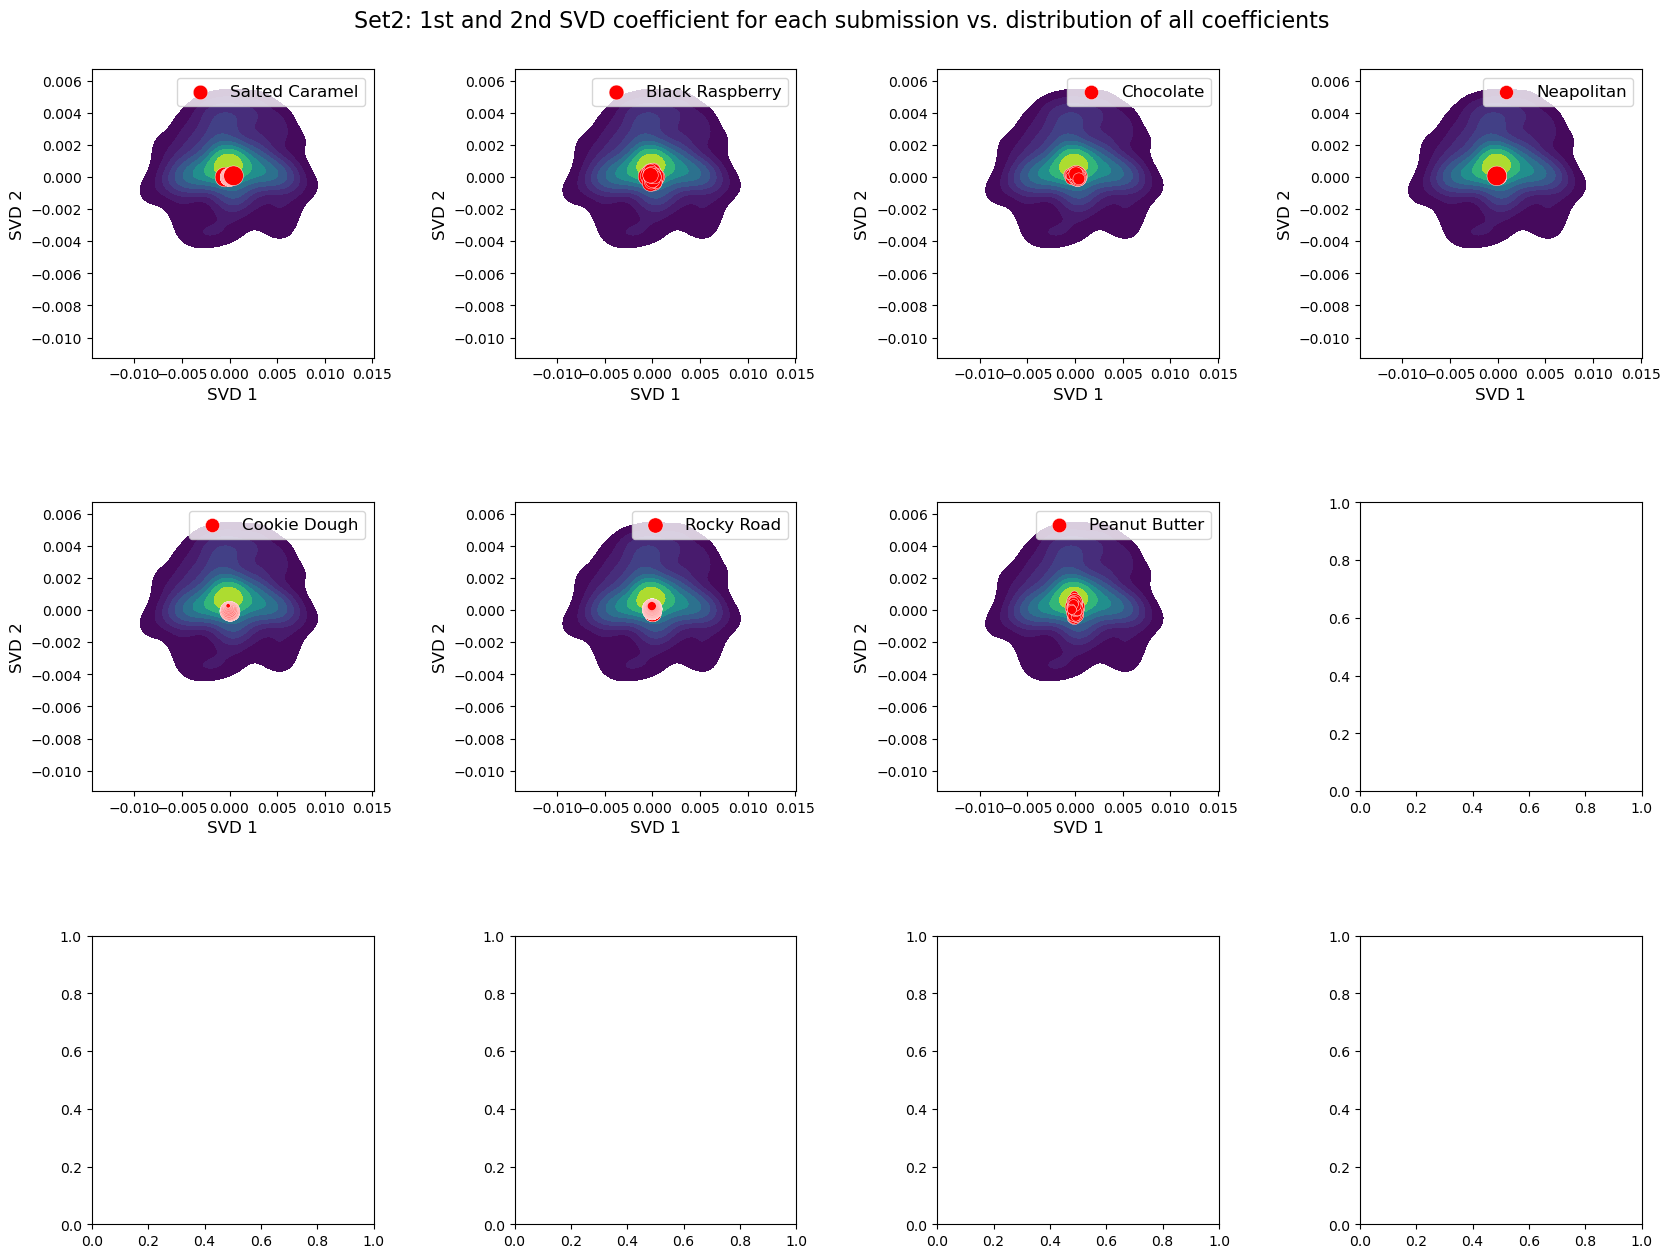

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(4 * 5, 3 * 5))
# fig.suptitle("KDEPlots for UMAP Embedding of SVD Coefficients for Set 2 with GT as reference")

for i, id in enumerate(data_svd_all_vs_all["metadata"].keys()):
    sns.kdeplot(
        x=data_svd_all_vs_all["coeffs"][:, 0],
        y=data_svd_all_vs_all["coeffs"][:, 1],
        cmap="viridis",
        fill=True,
        cbar=False,
        ax=ax.flatten()[i],
        weights=weights,
    )

    idx_0, idx_1 = data_svd_vs_gt["metadata"][id]["indices"]
    populations = data_svd_vs_gt["metadata"][id]["populations"]

    ax.flatten()[i].scatter(
        x=data_svd_vs_gt["coeffs"][idx_0:idx_1, 0],
        y=data_svd_vs_gt["coeffs"][idx_0:idx_1, 1],
        color="red",
        s=populations / populations.max() * 200,
        marker="o",
        linewidth=0.3,
        edgecolor="white",
        label=id,
    )

    ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
    ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
    ax.flatten()[i].legend(fontsize=12)


# adjust horizontal space
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle(
    "Set2: 1st and 2nd SVD coefficient for each submission vs. distribution of all coefficients",
    fontsize=16,
    y=0.92,
)